# Kernel Design

It's easy to make new kernels in GPflow. To demonstrate, we'll have a look at the Brownian motion kernel, whose function is 
$$
k(x, x') = \sigma^2 \text{min}(x, x')
$$
where $\sigma^2$ is a variance parameter. 

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
%matplotlib inline

To make this new kernel class, we inherit form the base class `gpflow.kernels.Kernel` and implement the three functions below. Note that depending on the kernel to be implemented other classes can be more adequate. For example, it is preferable to inherit from the base class `gpflow.kernels.Stationary` if the kernel to be implemented is stationnary.

#### `__init__`
The constructor takes no argument in this simple case (though it could, if that was convenient). It *must* call the constructor of the super class with appropriate arguments. In this case, the input_dim is always 1 (Brownian motion is only defined in 1D) and we'll assume the active_dims are [0], for simplicity.

We've added a parameter to the kernel using the Param class. Using this class lets the parameter be used in computing the kernel function, and it will automatically be recognised for optimization (or MCMC). Here, the variance parameter is initialized at 1, and constrained to be positive. 

#### `K`
This is where you implement the kernel function itself. This takes two arguments, X and X2. By convention, we make the second argument optional (defaults to None). 

Inside K, all the computation must be done with tensorflow -- here we've used `tf.minimum`. When GPflow executes the `K` function, X and X2 will be tensorflow tensors, and the `params_as_tensors` decorator turns the parameters such as self.variance into tensorflow tensors as well.

#### `Kdiag`
This convenience function allows GPflow to save memory at predict time. It's simply the diagonal of the `K` function, in the case where X2 is None. It must return a 1D vector, so we use tensorflow's reshape command.



In [2]:
class Brownian(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])
        self.variance = gpflow.Param(1.0, transform=gpflow.transforms.positive)

    @gpflow.params_as_tensors
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return self.variance * tf.minimum(X, tf.transpose(X2)) # this returns a 2D tensor

    @gpflow.params_as_tensors
    def Kdiag(self, X):
        return self.variance * tf.reshape(X, (-1,))            # this returns a 1D tensor

In the code above, one can see that the decorator `gpflow.params_as_tensors` is used on top of the definitions of `K` and `Kdiag`. Variables such as `self.variance` are of type *gpflow.Parameter*, which means they can't directly be multiplied or sumed with *tf.Tensors*, or used as inputs of tensorflow functions. The  `gpflow.params_as_tensors` decorator ensures that inside the function, this GPflow parametres are exposed as regular tensorflow variables. 

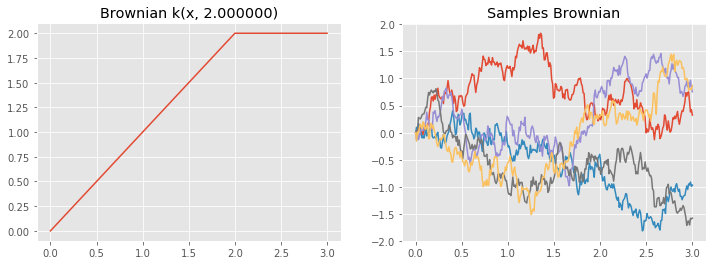

In [3]:
def plotkernelsample(k, ax, xmin=0, xmax=3):
    xx = np.linspace(xmin, xmax, 300)[:,None]
    K = k.compute_K_symm(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(300), K, 5).T)
    ax.set_title('Samples ' + k.__class__.__name__)

def plotkernelfunction(k, ax, xmin=0, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 100)[:,None]
    ax.plot(xx, k.compute_K(xx, np.zeros((1,1)) + other))
    ax.set_title(k.__class__.__name__ + ' k(x, %f)'%other)

k_brownian = Brownian()
f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
plotkernelfunction(k_brownian, axes[0], other=2.)
plotkernelsample(k_brownian, axes[1])

## Using the kernel in a model

Because we've inherited from the `Kernel` base class, this new kernel has all the properties needed to be used in GPflow. It also has some convenience features such as

`k.compute_K(X, X2)`

which allow the user to compute the kernel matrix using (and returning) numpy arrays. 

To show that this kernel works, let's use it inside GP regression. We'll see that Brownian motion has quite interesting properties. To add a little flexibility, we'll add a Constant kernel to our Brownian kernel, and the GPR class will handle the noise. 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5.294434
  Number of iterations: 26
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5.294434
  Number of iterations: 26
  Number of functions evaluations: 29


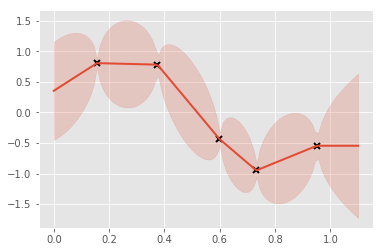

In [4]:
np.random.seed(42)
X = np.random.rand(5, 1)
Y = np.sin(X*6) + np.random.randn(*X.shape)*0.001

k1 = Brownian()
k2 = gpflow.kernels.Constant(1)
k = k1 + k2

m = gpflow.models.GPR(X, Y, kern=k)
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

xx = np.linspace(0, 1.1, 100).reshape(100, 1)
mean, var = m.predict_y(xx)
plt.plot(X, Y, 'kx', mew=2)
line, = plt.plot(xx, mean, lw=2)
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]),
                     color=line.get_color(), alpha=0.2)